## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_absolute_error

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive

import warnings
warnings.filterwarnings("ignore")

# 1. EDA / Preprocessing

In [3]:
# extract the data
df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
df = pd.read_csv("Datasets/full_2018_2023_prices.csv")
df.head(), df.shape

(                  Date  Price
 0  2018-01-01 00:00:00   4.74
 1  2018-01-01 01:00:00   3.66
 2  2018-01-01 02:00:00   1.26
 3  2018-01-01 03:00:00 -20.10
 4  2018-01-01 04:00:00 -31.82,
 (52584, 2))

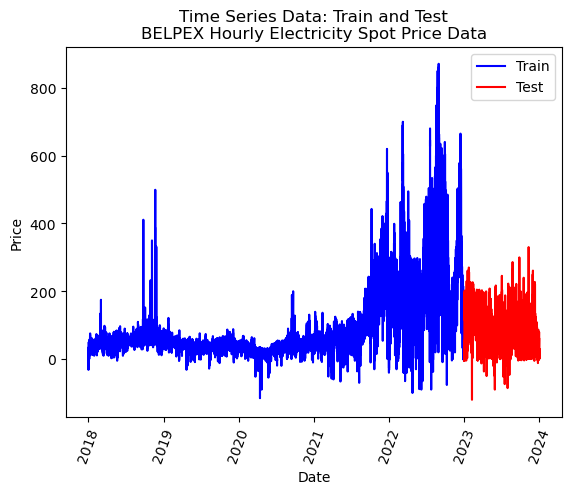

In [4]:
df["Date"] = pd.to_datetime(df["Date"])

train_df = df[df['Date'] < '2023-01-01']
test_df = df[df['Date'] >= '2023-01-01 00:00:00']


# Plot train dataset in blue
plt.plot(train_df["Date"], train_df["Price"], color='blue', label='Train')

# Plot test dataset in red
plt.plot(test_df["Date"], test_df["Price"], color='red', label='Test')

plt.xlabel('Date')
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.legend()
plt.title('Time Series Data: Train and Test\nBELPEX Hourly Electricity Spot Price Data')
plt.show()

In [5]:
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)
naive_df = test_df.copy()

In [6]:
train_df = train_df["Price"]
test_df = test_df["Price"]
train_data = train_df.values.reshape(-1, 1)
test_data = test_df.values.reshape(-1, 1)
train_data.shape, test_data.shape

((43824, 1), (8760, 1))

## Different scalar methods

In [7]:
from sklearn.preprocessing import PowerTransformer
from helper_functions.utils import DataScaler
# scale the data
#IS IT OKAY TO TRANSFORM TEST DATASETSET WITH SCALER FITTED ON TRAIN DATA
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)
# pt = PowerTransformer(method="yeo-johnson")
# scaler = pt.fit(train_data)
# train_data_scaled = scaler.transform(train_data)
# test_data_scaled = scaler.transform(test_data)

# scaler = DataScaler('Invariant')
# train_data_scaled = scaler.fit_transform(train_data)
# test_data_scaled = scaler.transform(test_data)

## Generating train & test sequences in correct format

In [8]:
n_lookback = 168  # length of input sequences (lookback period), 7*24H
n_forecast = 24  # length of output sequences (forecast period), 24H

def generate_train_pairs(raw_input, n_lookback, n_forecast):
    # generate the input and output sequences for training data

    X_train = []
    Y_train = []

    # This loop is designed to ensure that we can extract enough input-output pairs from the time series data
    for i in range(0, len(raw_input) - n_lookback - n_forecast + 1, 24):
        X_train.append(raw_input[i:i + n_lookback])  # Append a subsequence of length n_lookback from the y dataset
        Y_train.append(raw_input[i + n_lookback:i + n_lookback + n_forecast])  # Corresponding output sequence

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    return X_train, Y_train

X_train, Y_train = generate_train_pairs(train_data_scaled, n_lookback, n_forecast)
X_train.shape, Y_train.shape

((1819, 168, 1), (1819, 24, 1))

Samenstelling van X_test
- Eerste 6 dagen in test set heeft onvoldoende prijshistorie, dus vanaf dag 7 kan je forecast maken voor dag 8

In [9]:
# generate the input sequences for test data
X_test = []

# Iterate through the data with a step size of 24 hours
for i in range(0, len(test_data_scaled) - n_lookback + 1, 24):
    X_test.append(test_data_scaled[i:i + n_lookback])

X_test = np.array(X_test)

## Model setup parameters

In [10]:
scaler_type = "MIN MAX (0,1)"
multistep_technique = "Recursive multistep"
test_period = "1y"
train_period = "5y"
lookback_window = n_lookback
forecast_horizon = n_forecast
recalibration = "None"
calibration_window='Full history'

# Forecasting

## Naive forecaster
- For rMAE calculation

In [11]:
from helper_functions.utils import naive_forecast

# df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
# Naive forecaster copy of Jilles, i.e. Similar day model of 7 week prior (section 2.1 paper)

# # Y_pred_naive = [0] + test_data.flatten().tolist()[:-1]
# Y_pred_naive = 24*[np.NAN] + test_data[168:].flatten().tolist()[:-24]
# Y_pred_naive = np.array(Y_pred_naive)
# Y_pred_naive = pd.Series(data=Y_pred_naive)
# Y_pred_naive.fillna(method="backfill", inplace=True)
# Y_pred_naive = Y_pred_naive.to_numpy()
# Y_pred_naive.shape

# model = StatsForecast(models=[SeasonalNaive(season_length=7)],freq='H', n_jobs=-1)
# model.fit(train_df)

Y_pred_naive = naive_forecast(naive_df, m=None, n_prices_day=24)["Price"].to_numpy()
Y_pred_naive.shape

(8592,)

## LSTM: Recalibration code

Steps
- train model on train data
- get the forecasts for next 7 days by shifting window 1 day ahead every time
- evaluate (MAE / RMAE) for each new instance of the 7 days 
- add ground truth data of last 7 days to train set and remove last 7 days
- repeat

In [12]:
# Initialize the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# Define the checkpoint
checkpoint = tf.train.Checkpoint(model=model)

mae_list = []
Y_pred_list = []
Y_actual_list = []
recalibration_test = X_test

# Recalibration loop
for week in range(0,len(X_test) - 6, 7):  # Repeat for 7 days, do -6 because the last week isn't fully completed
    # Train the model on the train data
    print("[TRAINING MODEL...]")
    if week==0:
        model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=5)
    else:
        model.fit(X_train_new, Y_train_new, epochs=10, batch_size=32, verbose=5)
    
    # Get the 24h ahead forecasts for next 7 days
    for day in range(0, 7):
        # Generate forecasts for the next 24 hours
        # Prepare test data for forecasting, e.g., by shifting window
        # Predict
        Y_pred_scaled = model.predict(recalibration_test)
        Y_pred = scaler.inverse_transform(Y_pred_scaled[0].reshape((-1,1))) #reshape to get column vector!
        Y_actual = test_data[168:][((week+day)*24):(((week+day+1)*24))].flatten()
        # Evaluate (MAE / RMAE) for each new forecast horizon (24 hours)
        # Replace the evaluation code with your own metric calculation
        # mae = np.mean(np.abs(Y_pred - Y_actual))
        print(Y_actual.shape, Y_pred.shape)
        if Y_actual.shape[0] == 0:
            continue
        mae = mean_absolute_error(Y_actual, Y_pred)
        rmae = np.sqrt(np.mean(np.square(Y_pred - Y_actual)))
        print(f"Week {round(week/7)} Day {day}: MAE = {mae}, RMAE = {rmae}")
        mae_list.append(mae)
        Y_pred_list.append(Y_pred)
        Y_actual_list.append(Y_actual)
        if len(recalibration_test) > 1:
            recalibration_test = recalibration_test[1:]
        else:
            continue
    # Add ground truth data of last 7 days to train set and remove last 7 days
    train_data_scaled = np.append(train_data_scaled, test_data_scaled[24*7*(week):24*(week+1)*7])
    train_data_scaled = train_data_scaled[7*24:]
    X_train_new, Y_train_new = generate_train_pairs(train_data_scaled, n_lookback, n_forecast)
    X_train_new = np.expand_dims(X_train_new, axis=2)
    Y_train_new = np.expand_dims(Y_train_new, axis=2)
    print(X_train_new.shape, Y_train_new.shape)
    # Save the model weights
    checkpoint.save('./checkpoints/my_checkpoint')
    
    # Restore the model weights before the next iteration
    # This ensures that we are only updating the weights slightly
    checkpoint.restore(tf.train.latest_checkpoint('./checkpoints/'))



[TRAINING MODEL...]
Epoch 1/50



KeyboardInterrupt: 

In [ ]:
# Calculate the mean MAE and RMAE
mae_pred = np.mean(mae_list)
mae_naive = mean_absolute_error(np.concatenate(Y_actual_list), Y_pred_naive)
mae_pred, mae_naive

(60.39384130577247, 68.95572488584476)

### Visualize output

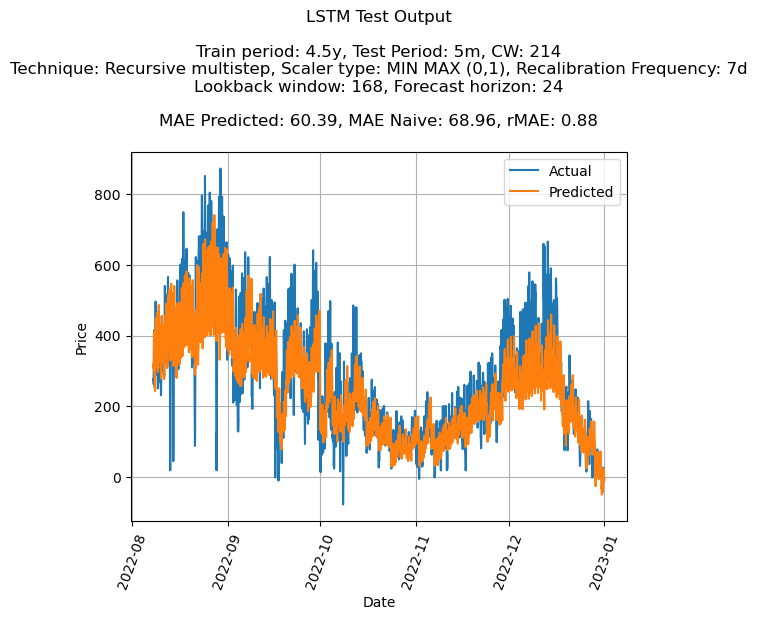

In [133]:
x_ticks = test_df.index[168:]

title = f"""LSTM Test Output\n
Train period: {train_period}, Test Period: {test_period}, CW: {calibration_window}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

plt.plot(x_ticks, np.concatenate(Y_actual_list), label="Actual")
plt.plot(x_ticks, np.concatenate(Y_pred_list), label="Predicted")
# plt.plot(x_ticks, Y_pred_naive, label="Persistence", alpha=0.5)
plt.title(title)
plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

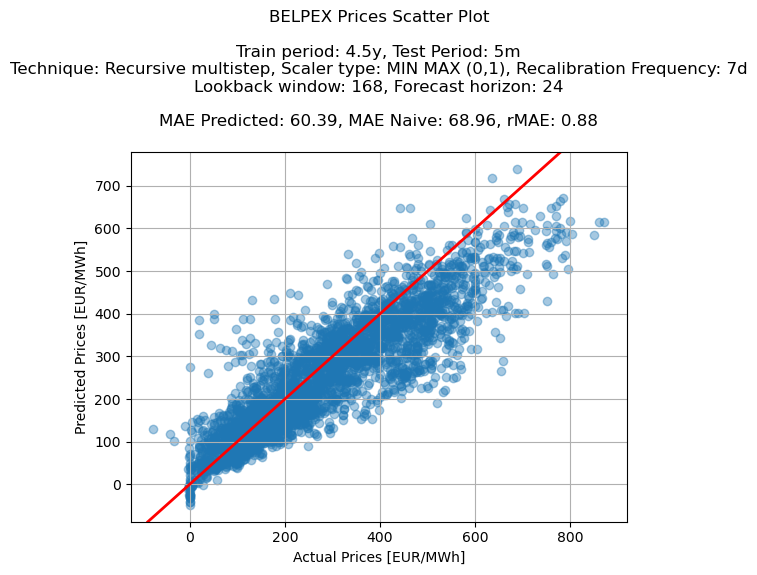

In [134]:
fig, ax = plt.subplots()

title =f"""
Train period: {train_period}, Test Period: {test_period}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

ax.axline((0, 0), slope=1, color='r', linewidth=2)
ax.scatter(x=np.concatenate(Y_actual_list), y=np.concatenate(Y_pred_list), alpha = 0.4)
ax.grid(True)
ax.set_xlabel("Actual Prices [EUR/MWh]")
ax.set_ylabel("Predicted Prices [EUR/MWh]")
plt.title(f"BELPEX Prices Scatter Plot\n{title}")
plt.show()

## LSTM: No Recalibration

In [13]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mean_squared_error", "mean_absolute_error"])
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=5)

Epoch 1/50

Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error'])


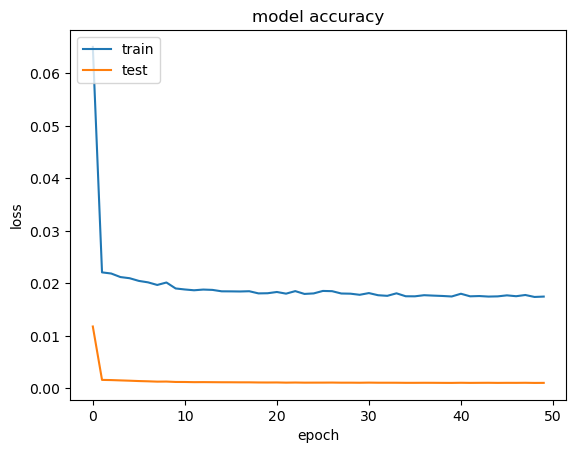

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [15]:
# generate predictions
Y_pred_scaled = model.predict(X_test)
# Inverse scaling
Y_pred = scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)).squeeze()[:-24] #reshape to get column vector!
Y_actual = test_data[n_lookback:].flatten()
Y_pred.shape, Y_actual.shape

12/12 [==============================] - 1s 18ms/step


((8592,), (8592,))

In [16]:
mae_pred = mean_absolute_error(Y_actual, Y_pred.flatten())
mae_naive = mean_absolute_error(Y_actual, Y_pred_naive)
mae_pred, mae_naive

(29.036731430382034, 32.153490456238366)

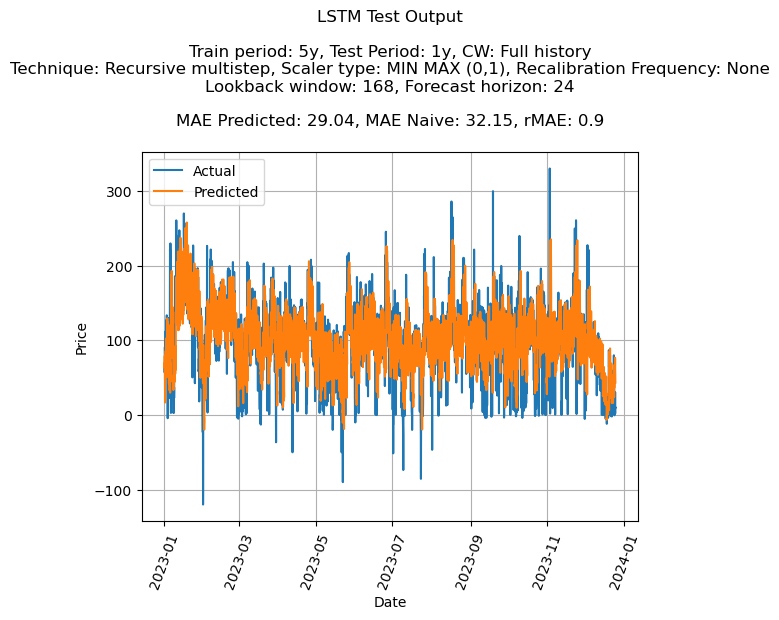

In [17]:
x_ticks = test_df.index[:-168]

title = f"""LSTM Test Output\n
Train period: {train_period}, Test Period: {test_period}, CW: {calibration_window}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

plt.plot(x_ticks, Y_actual, label="Actual")
plt.plot(x_ticks, Y_pred, label="Predicted")
# plt.plot(x_ticks, Y_pred_naive, label="Persistence", alpha=0.5)
plt.title(title)
plt.legend()
plt.xticks(rotation=70)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

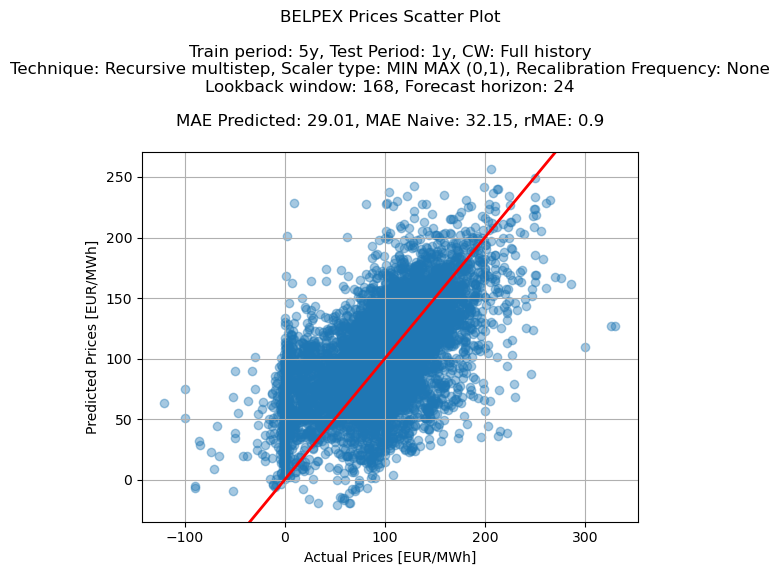

In [166]:
fig, ax = plt.subplots()

title =f"""
Train period: {train_period}, Test Period: {test_period}, CW: {calibration_window}
Technique: {multistep_technique}, Scaler type: {scaler_type}, Recalibration Frequency: {recalibration}
Lookback window: {lookback_window}, Forecast horizon: {forecast_horizon}\n
MAE Predicted: {round(mae_pred,2)}, MAE Naive: {round(mae_naive, 2)}, rMAE: {round(mae_pred/mae_naive, 2)}
"""

ax.axline((0, 0), slope=1, color='r', linewidth=2)
ax.scatter(x=Y_actual, y=Y_pred, alpha = 0.4)
ax.grid(True)
ax.set_xlabel("Actual Prices [EUR/MWh]")
ax.set_ylabel("Predicted Prices [EUR/MWh]")
plt.title(f"BELPEX Prices Scatter Plot\n{title}")
plt.show()

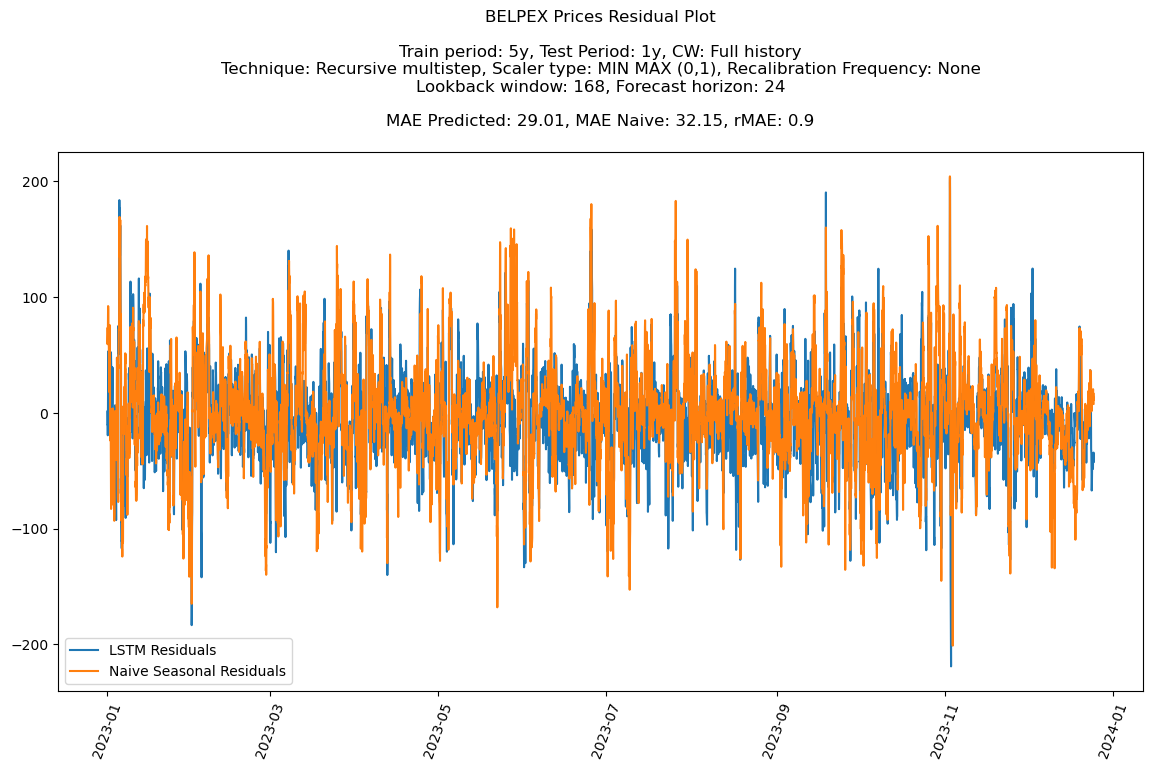

In [167]:
lstm_residuals = Y_actual - Y_pred
naive_residuals = Y_actual - Y_pred_naive

plt.figure(figsize=(14, 7))
plt.plot(x_ticks, lstm_residuals, label='LSTM Residuals')
plt.plot(x_ticks, naive_residuals, label='Naive Seasonal Residuals')
plt.title(f"BELPEX Prices Residual Plot\n{title}")
plt.legend()
plt.xticks(rotation=70)
plt.show()

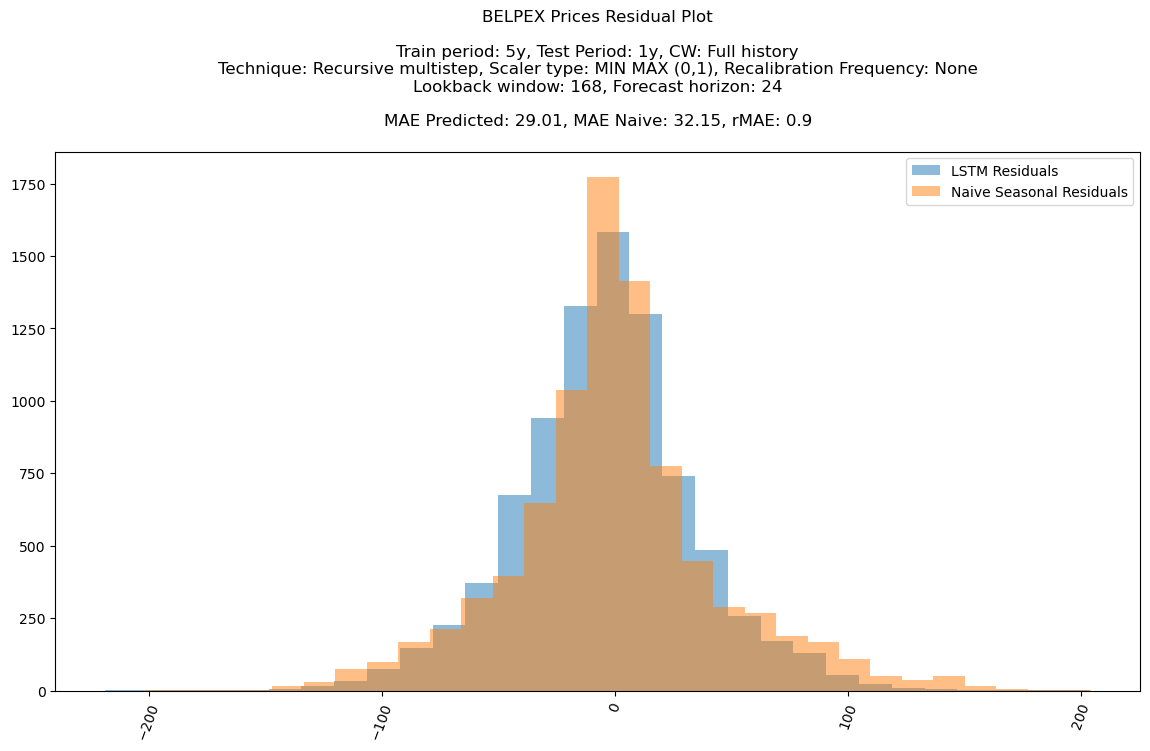

In [168]:
plt.figure(figsize=(14, 7))
plt.hist(lstm_residuals, bins=30, alpha=0.5, label='LSTM Residuals')
plt.hist(naive_residuals, bins=30, alpha=0.5, label='Naive Seasonal Residuals')
plt.title(f"BELPEX Prices Residual Plot\n{title}")
plt.legend()
plt.xticks(rotation=70)
plt.show()

In [35]:
from helper_functions.dm import dm_test
from helper_functions.gw import GW

dm = dm_test(Y_actual,Y_pred,Y_pred_naive,h = 24, crit="MSE")

Y_actual_gw = Y_actual.reshape(-1, 24).astype(float)
Y_pred_gw = Y_pred.reshape(-1, 24).astype(float)
Y_pred_naive_gw = Y_pred_naive.reshape(-1, 24).astype(float)

gw = GW(Y_actual_gw, Y_pred_gw, Y_pred_naive_gw, norm=1, version='univariate')

print(f"Diabold Mariano Test: {dm}\nGiacomini-White Test: {gw}")

Diabold Mariano Test: dm_return(DM=-4.0544298421716, p_value=5.0700430700819606e-05)
Giacomini-White Test: [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.74146151e-03 1.39459083e-08 2.43933888e-02 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 2.18042546e-01 3.15894582e-02 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]


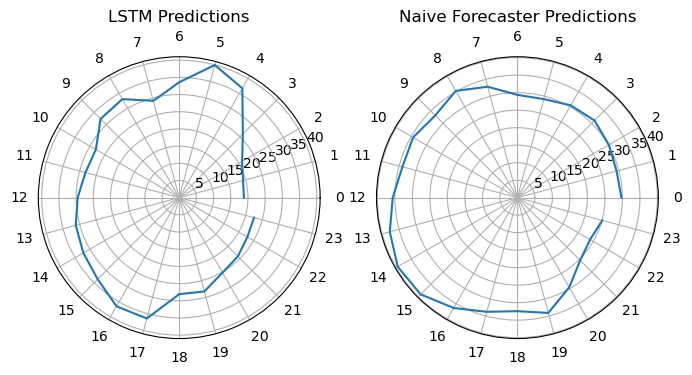

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each hour
mae_lstm = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_gw[:, i]) for i in range(24)]
mae_naive = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_naive_gw[:, i]) for i in range(24)]

# Convert hours to radians
hours = np.linspace(0, 2*np.pi, 24, endpoint=False)

# Create clock chart for LSTM predictions
plt.figure(figsize=(8, 8))
ax = plt.subplot(121, polar=True)
ax.plot(hours, mae_lstm)
ax.set_xticks(hours)
ax.set_xticklabels(range(24))
ax.set_title('LSTM Predictions')

# Create clock chart for naive forecaster predictions
ax = plt.subplot(122, polar=True)
ax.plot(hours, mae_naive)
ax.set_xticks(hours)
ax.set_xticklabels(range(24))
ax.set_title('Naive Forecaster Predictions')
# ax.set_yticklabels('MAE')
plt.show()

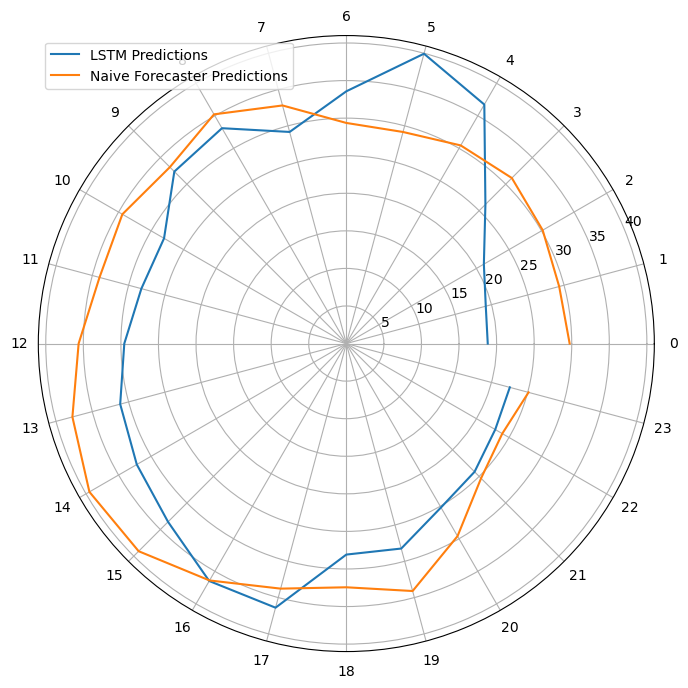

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each hour
mae_lstm = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_gw[:, i]) for i in range(24)]
mae_naive = [mean_absolute_error(Y_actual_gw[:, i], Y_pred_naive_gw[:, i]) for i in range(24)]

# Convert hours to radians
hours = np.linspace(0, 2*np.pi, 24, endpoint=False)

# Create clock chart for LSTM and naive forecaster predictions
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(hours, mae_lstm, label='LSTM Predictions')
ax.plot(hours, mae_naive, label='Naive Forecaster Predictions')
ax.set_xticks(hours)
ax.set_xticklabels(range(24))
ax.legend()

plt.show()